In [2]:
import os
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, GroupKFold
import scipy
import anndata
import shap

In [3]:
%matplotlib inline
from tqdm.notebook import tqdm
import gc
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## data load

In [4]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'

model_path_for_now = '/dss/dsshome1/02/di93zoj/valentina/open-problems-multimodal-3rd-solution/'

raw_path =  lrz_path + 'input/raw/'  # '../../../input/raw/'

cite_target_path = lrz_path + 'input/target/cite/'   # '../../../input/target/cite/'
cite_feature_path = lrz_path + 'input/features/cite/'   # '../../../input/features/cite/'
cite_mlp_path = lrz_path + 'model/cite/mlp/'   # '../../../model/cite/mlp/'   # '../../../model/cite/mlp/'
cite_cb_path = lrz_path + 'model/cite/cb/'   # '../../../model/cite/cb/'

multi_target_path = lrz_path + 'input/target/multi/'   # '../../../input/target/multi/'
multi_feature_path = lrz_path + 'input/features/multi/'   # '../../../input/features/multi/'
multi_mlp_path = lrz_path + 'model/multi/mlp/'   # '../../../model/multi/mlp/'
multi_cb_path = lrz_path + 'model/multi/cb/'   # '../../../model/multi/cb/'

index_path = lrz_path + 'input/preprocess/cite/'

output_path = lrz_path + 'output/'   # '../../../output/'

## Cite

In [5]:
mlp_model_name = [
    'corr_add_con_imp',
    'corr_last_v3', 
    'corr_c_add_w2v_v1_mish_flg',
    'corr_c_add_w2v_v1_flg',
    'corr_c_add_84_v1',
    'corr_c_add_120_v1',
    'corr_w2v_cell_flg',
    'corr_best_cell_120',
    'corr_cluster_cell',
    'corr_w2v_128',
    'corr_imp_w2v_128',
    'corr_snorm',
    'corr_best_128',
    'corr_best_64',
    'corr_cluster_128',
    'corr_cluster_64',
    'corr_svd_128',
    'corr_svd_64',
             ]

In [6]:
model_name_list = []

for i in mlp_model_name:
    for num, j in enumerate(os.listdir(cite_mlp_path)):
        if i in j:
            model_name_list.append(j)

len(model_name_list)
model_name_list

['cite_mlp_corr_add_con_imp_flg_donor_val_50',
 'cite_mlp_corr_last_v3_flg_donor_val_55',
 'cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66',
 'cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66',
 'cite_mlp_corr_c_add_84_v1_flg_donor_val_47',
 'cite_mlp_corr_c_add_120_v1_flg_donor_val_63',
 'cite_mlp_corr_w2v_cell_flg_donor_val_51',
 'cite_mlp_corr_best_cell_120_flg_donor_val_51',
 'cite_mlp_corr_cluster_cell_flg_donor_val_64',
 'cite_mlp_corr_w2v_128_flg_donor_val_42',
 'cite_mlp_corr_imp_w2v_128_flg_donor_val_38',
 'cite_mlp_corr_snorm_flg_donor_val_39',
 'cite_mlp_corr_best_128_flg_donor_val_45',
 'cite_mlp_corr_best_64_flg_donor_val_50',
 'cite_mlp_corr_cluster_128_flg_donor_val_51',
 'cite_mlp_corr_cluster_64_flg_donor_val_57',
 'cite_mlp_corr_svd_128_flg_donor_val_30',
 'cite_mlp_corr_svd_64_flg_donor_val_38']

In [7]:
weight = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]
weight_sum = np.array(weight).sum()
weight_sum

model_feat_dict = {model_name_list[0]:['X_test_add_con_imp.pickle', 1],
                   model_name_list[1]:['X_test_last_v3.pickle', 0.3],
                   model_name_list[2]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[3]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[4]:['X_test_c_add_84_v1.pickle', 1],
                   model_name_list[5]:['X_test_c_add_v1.pickle', 1],
                   
                   model_name_list[6]:['X_test_feature_w2v_cell.pickle', 1],
                   model_name_list[7]:['X_test_best_cell_128_120.pickle', 1],
                   model_name_list[8]:['X_test_cluster_cell_128.pickle', 1],
                   
                   model_name_list[9]:['X_test_feature_w2v.pickle', 0.8],
                   model_name_list[10]:['X_test_feature_imp_w2v.pickle',0.8],
                   model_name_list[11]:['X_test_feature_snorm.pickle', 0.8],
                   model_name_list[12]:['X_test_best_128.pickle', 0.8],
                   model_name_list[13]:['X_test_best_64.pickle', 0.5],
                   model_name_list[14]:['X_test_cluster_128.pickle', 0.5],
                   model_name_list[15]:['X_test_cluster_64.pickle', 0.5],
                   model_name_list[16]:['X_test_svd_128.pickle', 1],
                   model_name_list[17]:['X_test_svd_64.pickle', 1],
                   
                   'best_128':['X_test_best_128.pickle', 2],
                   'best_64':['X_test_best_64.pickle', 2],
                  }

### cite model

In [8]:
def std(x):
    x = np.array(x)
    return (x - x.mean(1).reshape(-1, 1)) / x.std(1).reshape(-1, 1)

In [9]:
class CiteDataset(Dataset):
    
    def __init__(self, feature, target):
        
        self.feature = feature
        self.target = target
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index],
            "y" : self.target[index],
        }
        return d

In [10]:
class CiteDataset_test(Dataset):
    
    def __init__(self, feature):
        self.feature = feature
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index]
        }
        return d

In [11]:
def partial_correlation_score_torch_faster(y_true, y_pred):
    """Compute the correlation between each rows of the y_true and y_pred tensors.
    Compatible with backpropagation.
    """
    y_true_centered = y_true - torch.mean(y_true, dim=1)[:,None]
    y_pred_centered = y_pred - torch.mean(y_pred, dim=1)[:,None]
    cov_tp = torch.sum(y_true_centered*y_pred_centered, dim=1)/(y_true.shape[1]-1)
    var_t = torch.sum(y_true_centered**2, dim=1)/(y_true.shape[1]-1)
    var_p = torch.sum(y_pred_centered**2, dim=1)/(y_true.shape[1]-1)
    return cov_tp/torch.sqrt(var_t*var_p)

def correl_loss(pred, tgt):
    """Loss for directly optimizing the correlation.
    """
    return -torch.mean(partial_correlation_score_torch_faster(tgt, pred))

In [12]:
class CiteModel(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.ReLU(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.ReLU(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.ReLU(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
        
        from_numpy = False
        
      ##
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            from_numpy = True
        X = X.to(device)  # Move the input to the appropriate device if necessary
        ##
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        if from_numpy:
            out = out.cpu().detach().numpy()
            
        return out

In [13]:
class CiteModel_mish(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel_mish, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.Mish(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.Mish(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.Mish(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
    
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        return out

In [14]:
def train_loop(model, optimizer, loader, epoch):
    
    losses, lrs = [], []
    model.train()
    optimizer.zero_grad()
    #loss_fn = nn.MSELoss()
    
    with tqdm(total=len(loader),unit="batch") as pbar:
        pbar.set_description(f"Epoch{epoch}")
        
        for d in loader:
            X = d['X'].to(device)
            y = d['y'].to(device)
            
            logits = model(X)
            loss = correl_loss(logits, y)
            #loss = torch.sqrt(loss_fn(logits, y))
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix({"loss":loss.item()})
            pbar.update(1)

    return model

In [15]:
def valid_loop(model, loader, y_val):
    
    model.eval()
    partial_correlation_scores = []
    oof_pred = []
    
    for d in loader:
        with torch.no_grad():
            val_X = d['X'].to(device).float()
            val_y = d['y'].to(device)
            logits = model(val_X)
            oof_pred.append(logits)
    
    #print(torch.cat(oof_pred).shape, torch.cat(oof_pred).detach().cpu().numpy().shape)
    cor = partial_correlation_score_torch_faster(torch.tensor(y_val).to(device), torch.cat(oof_pred))
    cor = cor.mean().item()
    logits = torch.cat(oof_pred).detach().cpu().numpy()
    
    return logits, cor

In [16]:
def test_loop(model, loader):
    
    model.eval()
    predicts=[]

    for d in tqdm(loader):
        with torch.no_grad():
            X = d['X'].to(device)
            logits = model(X)
            predicts.append(logits.detach().cpu().numpy())
            
    return np.concatenate(predicts)

### pred #17

In [17]:
# model #17: 'cite_mlp_corr_svd_64_flg_donor_val_38'
pred_17 = np.zeros([48203, 140])

i = 'cite_mlp_corr_svd_64_flg_donor_val_38'
        
test_file = model_feat_dict[i][0]
test_weight = model_feat_dict[i][1]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

test_ds = CiteDataset_test(X_test)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                              shuffle=False, drop_last=False, num_workers=4)

if 'mish' in i:
    model = CiteModel_mish(feature_dims)
else:
    model = CiteModel(feature_dims)
    
model = model.to(device)
model.load_state_dict(torch.load(f'{cite_mlp_path}/{i}'))

result = test_loop(model, test_dataloader).astype(np.float32)
pred_17 += result

torch.cuda.empty_cache()
        
pd.DataFrame(pred_17)

  0%|          | 0/377 [00:00<?, ?it/s]

0         1         2         3         4         5         6    \
0     -1.485929 -1.648590 -1.354192  1.337131  0.899848  3.840804  5.417696   
1     -1.341331 -1.628273 -1.359688  1.229825  1.017240  3.907094  5.831196   
2     -1.305131 -1.523334 -1.222074  1.948306  1.540086  2.152886  6.987280   
3     -1.610347 -1.364953 -1.083853  0.927689  0.863880  0.418486 -1.705329   
4     -1.364571 -1.405219 -1.130174  1.505317  1.719770  2.873801  0.273011   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -0.637254 -1.540931 -1.290375  1.334099  1.179155  3.150467  5.239079   
48199 -0.963616 -1.506297 -1.287971  0.274215  0.748704  3.043756  2.446438   
48200 -1.208977 -0.697696 -0.887223 -0.056984  0.556801  0.958912 -1.336028   
48201 -1.594536 -1.511445 -1.072897  0.845717  0.018894  1.088687 -1.761857   
48202 -1.661282 -1.345528 -1.079496  0.834897 -0.588339  1.931948 -1.574667   

            7         8         9         10        11        12        13   \
0     -1.682970 -1.580891 -1.278234 -1.729914 -1.677031 -1.374618 -1.632938   
1     -1.681241 -1.573870 -1.312515 -1.723778 -1.650451 -1.421604 -1.596047   
2     -1.518160 -1.429220 -1.471982 -1.605948 -1.475161 -1.423977 -1.457950   
3     -1.281271 -1.262010 -1.504402 -1.692404 -1.439577 -1.479383 -1.447558   
4     -1.502218 -1.230294 -1.310860 -1.586461 -1.525964 -1.406389 -1.417096   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -1.610555 -1.466837 -1.367435 -1.660446 -1.574016 -1.404232 -1.540480   
48199 -1.632615 -1.513172 -1.012835 -1.673611 -1.658362 -1.311918 -1.496316   
48200 -0.367204 -1.101079 -1.090064 -1.233806 -1.213969 -1.065547 -1.030910   
48201 -1.299165 -1.075207 -1.511891 -1.737581 -1.505562 -1.483749 -1.320952   
48202 -1.414230 -0.989736 -1.606483 -1.724306 -1.390952 -1.348535 -1.249009   

            14        15        16        17        18        19        20   \
0      4.032374 -1.309875  2.852930  1.914089  0.072447 -1.615627 -1.523367   
1      3.628891 -1.336422  2.750767  2.234595 -0.241775 -1.536112 -1.524295   
2      5.978767 -1.108689  1.256656  1.732708 -0.956647 -1.552443 -1.418248   
3      2.845503 -1.484085  0.796883 -1.545334 -0.880862 -0.831662 -1.368447   
4      2.572745 -1.123792  2.031264 -0.373281  0.251721 -1.699311 -1.293683   
...         ...       ...       ...       ...       ...       ...       ...   
48198  4.237601 -1.340678  2.791385  1.844838 -0.067452 -1.579793 -1.460040   
48199  3.001552 -1.244972  2.202162  2.322878  0.260145 -1.653070 -1.522676   
48200 -0.760301 -1.136053  0.750087 -1.236239 -0.917200 -1.171487 -1.020247   
48201  1.396094 -1.660476  0.609579 -1.470598 -1.370884 -1.184970 -1.274588   
48202  1.264856 -1.639934 -0.154179 -1.479224 -1.344604 -1.395638 -0.625298   

            21        22        23        24        25        26        27   \
0      0.072543 -1.678322 -1.373716  4.597494 -1.705482 -1.740377 -1.651625   
1      0.021340 -1.656302 -1.422014  4.987586 -1.692348 -1.723668 -1.645522   
2      0.064189 -1.534678 -1.308441  4.818275 -1.574301 -1.598540 -1.577123   
3      0.500830 -1.433816 -1.316891  1.715705 -1.564376 -1.615827 -1.656384   
4      0.342740 -1.576555 -1.400123  6.335351 -1.514777 -1.624030 -1.551304   
...         ...       ...       ...       ...       ...       ...       ...   
48198 -0.133060 -1.598139 -1.139350  4.842281 -1.683305 -1.686182 -1.552641   
48199 -0.186245 -1.648112 -1.052786  4.441164 -1.677041 -1.730664 -1.519968   
48200  2.030039 -1.036028 -0.934959 -0.936805 -1.153219 -1.187423 -1.135973   
48201  1.438030 -1.614122 -1.211228  1.978016 -1.550579 -1.771553 -1.741008   
48202  1.412553 -1.635870 -1.176170  2.223085 -1.490494 -1.661535 -1.678386   

            28        29        30        31        32        33        34   \
0     -1.719589 -1.658640 -1.673890 -1.618853 -1.627443 -1.611647 -1.637881   
1     -1.740092 -1.656937 -1.674017 -1.598789 -1.617187 -1

### - add cell_ids to train and test data
### - SHAP

In [18]:
train_ids = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)

train_index = train_ids["index"]
train_column = train_ids["columns"]
test_index = test_ids["index"]
print(len(list(train_index)))
print(len(list(test_index)))
X_train_cell_ids = pd.read_pickle(cite_feature_path  + 'X_svd_64.pickle')
X_train_cell_ids.index = train_index
X_train_cell_ids

70988
48203


base_svd_0  base_svd_1  base_svd_2  base_svd_3  base_svd_4  \
45006fe3e4c8   85.127525   -5.213055   -9.165959    2.846739   -8.685139   
d02759a80ba2   84.172943   -3.234958  -11.785313    4.179020   -9.126358   
c016c6b0efa5   83.272850   -5.525706   -0.661822    4.323725   10.823936   
ba7f733a4f75   91.434578   -3.291388   -0.577375  -11.340739   -3.523063   
fbcf2443ffb2   93.313927  -11.030456    9.194694   -3.865815    1.862929   
...                  ...         ...         ...         ...         ...   
650ee456f0f3   80.523338   -2.106768   -6.517686    6.813876   -5.033510   
cc506e7707f5   88.921173  -12.732532    7.068761    2.051868    3.950980   
a91f1b55a520   87.540184   -5.719145    5.090394    4.244038   11.409257   
3a9882c98205   89.632416    6.399195    7.434003  -14.750739    1.367248   
c91b6b2ccd3d   84.178047   -3.164156    1.913218    7.093866    7.283124   

              base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  \
45006fe3e4c8    1.042536    1.625903    0.618721   -2.840382    0.843463   
d02759a80ba2    4.196976    1.780043   -0.646773    1.248082   -1.225247   
c016c6b0efa5    7.771118   -5.908740   -4.019240    2.342926    2.447080   
ba7f733a4f75    5.469267    6.948770   -1.133049    0.475752    2.398257   
fbcf2443ffb2    1.327409   -2.211941    0.308439   -8.437016    1.691900   
...                  ...         ...         ...         ...         ...   
650ee456f0f3    1.806359    0.526864   -3.493208    1.905617   -1.989778   
cc506e7707f5    4.776481    0.759009   -2.568171    2.431149    4.065109   
a91f1b55a520    4.688541   -4.086064   -4.571492    1.658255    0.819807   
3a9882c98205    3.140962    1.040011    1.786080   -5.499776   -3.747795   
c91b6b2ccd3d    4.032661   -0.595088   -1.979079   -5.817008   -2.345232   

              base_svd_10  base_svd_11  base_svd_12  base_svd_13  base_svd_14  \
45006fe3e4c8     4.115457     0.026768    -1.138766    -2.111132     0.099473   
d02759a80ba2     4.099039     3.395518     0.073547    -1.664226    -1.158406   
c016c6b0efa5     2.766433    -0.793214     0.338952    -1.861409    -0.396700   
ba7f733a4f75    -0.938886     2.287829     1.342482    -1.258590     0.583942   
fbcf2443ffb2    -4.529302    -1.198637     1.674134    -2.604135     0.094962   
...                   ...          ...          ...          ...          ...   
650ee456f0f3    -1.776527    -1.504293    -3.820674    -2.135952    -0.164970   
cc506e7707f5    -2.780729    -1.427456    -0.259329    -1.230658    -0.751350   
a91f1b55a520     1.048128     2.144186     1.174608     1.229994    -0.820600   
3a9882c98205    -0.314418    -4.190456     3.512170    -2.081214     4.806989   
c91b6b2ccd3d     2.189953     1.824760    -4.687482     0.086324     0.658919   

              base_svd_15  base_svd_16  base_svd_17  base_svd_18  base_svd_19  \
45006fe3e4c8     1.337587    -0.593598    -0.754882     1.756984     1.104489   
d02759a80ba2    -3.064262    -0.290169    -0.024956     0.736002    -0.166101   
c016c6b0efa5    -3.334156     0.467634     0.910031     1.036321    -2.196117   
ba7f733a4f75    -1.853231     2.061509    -3.389291     2.775279     2.047321   
fbcf2443ffb2    -2.018295    -0.372481     0.157291     0.728967    -2.445016   
...                   ...          ...          ...          ...          ...   
650ee456f0f3     1.014745    -1.092490     1.688265    -2.726075    -1.984250   
cc506e7707f5     2.807976     0.224903    -1.985697    -2.812946    -0.030470   
a91f1b55a520    -1.769524     2.705869     3.951199    -0.771722    -0.526195   
3a9882c98205    -0.065257     0.624472     5.759660    -1.517653     0.460531   
c91b6b2ccd3d     1.799805     0.471818     1.385172    -0.748671     2.009529   

              base_svd_20  base_svd_21  base_svd_22  base_svd_23  base_svd_24  \
45006fe3e4c8     0.553422     1.499282     1.035930    -0.274265    -1.365731   
d02759a80ba2    -0.807669     0.509812     0.695613    -0.010259     1.299255   

In [19]:
# cell type from metadata
X_test_cell_ids = pd.read_pickle(cite_feature_path  + test_file)
X_test_cell_ids.index = test_index
X_test_cell_ids

base_svd_0  base_svd_1  base_svd_2  base_svd_3  base_svd_4  \
83d6659a6a32   94.057228   -7.824670    0.389765  -11.240484    1.049251   
d98594f13d2e   92.369606   -4.847714    0.514461   -8.376906   -1.919543   
5f93d8ffc72f   90.293884    0.146889   -0.270509  -10.908735   -3.213930   
7dfa2699d351   93.806755  -12.446421   10.554243   -0.710657    4.603795   
6d2533edd0e0   88.559273  -11.090321   -5.712635    2.695315  -10.597576   
...                  ...         ...         ...         ...         ...   
a9b4d99f1f50   85.367889    1.081190   -8.010024    0.796157   -3.397080   
0e2c1d0782af   81.206764    6.504639  -10.942367    2.146884    1.046683   
a3cbc5aa0ec3   80.427071    7.672887   15.709313   15.694386    8.388478   
75b350243add   84.337372   -3.197394    1.886373    5.541956   13.938196   
ad5a949989b2   87.707191  -10.011003    5.631380    3.797773    8.066488   

              base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  \
83d6659a6a32   -6.360489   -0.291210   -0.807010    1.523493    4.391251   
d98594f13d2e   -4.256641   -1.350071    5.257890    1.823014    2.320892   
5f93d8ffc72f    5.237501    3.356637    3.374693    2.552806    0.776578   
7dfa2699d351   -2.805276    1.067937    1.833109   -4.609187   -0.201022   
6d2533edd0e0    1.776097    1.813141    3.325570   -5.384142    0.696405   
...                  ...         ...         ...         ...         ...   
a9b4d99f1f50    1.601640    3.457679   -1.218029    0.785743    4.255200   
0e2c1d0782af   -0.758358    1.365240   -1.824342    1.040798    4.043053   
a3cbc5aa0ec3   -5.821045   22.260235    1.316712    0.245468   -0.062428   
75b350243add    6.305661   -4.406522   -3.570666    2.691317    0.877459   
ad5a949989b2    9.829962   -6.497011    2.368653    4.273610    3.917652   

              base_svd_10  base_svd_11  base_svd_12  base_svd_13  base_svd_14  \
83d6659a6a32     1.059340     1.106116     2.795475     0.232935     0.484662   
d98594f13d2e     2.635873     2.633115     0.983698     0.518591     0.126842   
5f93d8ffc72f     0.539208     3.613595     1.006866     0.078750     2.190635   
7dfa2699d351    -3.963815    -0.005474    -1.097554    -1.379830     0.760483   
6d2533edd0e0     1.564074    -0.764844    -0.381060    -0.970234    -0.081099   
...                   ...          ...          ...          ...          ...   
a9b4d99f1f50    -2.754606     0.383240     2.924001     1.192756    -3.223065   
0e2c1d0782af    -0.935726     0.734674    -1.796999     2.394762    -2.456163   
a3cbc5aa0ec3     6.347752     0.138975     0.054170    -0.312665    -1.176165   
75b350243add     3.527270     0.154592     1.377090     0.823804    -1.125078   
ad5a949989b2     3.833547     0.275184     1.520376     1.476980     0.950853   

              base_svd_15  base_svd_16  base_svd_17  base_svd_18  base_svd_19  \
83d6659a6a32     0.611221     1.097876    -3.670536    -2.155238     0.258782   
d98594f13d2e     0.306399     1.275106    -2.075083    -2.542139     0.761321   
5f93d8ffc72f    -0.774920     2.768196    -2.702330    -0.786495     1.249743   
7dfa2699d351    -3.148124     2.914077     0.108751     0.023305     1.434091   
6d2533edd0e0     1.174093     1.231571    -2.816500     0.670269    -1.157700   
...                   ...          ...          ...          ...          ...   
a9b4d99f1f50     0.136501     0.360003     0.193125    -3.446376    -1.679001   
0e2c1d0782af     0.073401    -1.517218     0.663072    -3.999555    -0.804537   
a3cbc5aa0ec3     1.310694     1.000180     0.877849    -3.324973     0.133367   
75b350243add    -1.530653     2.027968     1.793543    -0.622746    -0.945343   
ad5a949989b2     0.124969     0.364755    -1.352709    -2.169170    -0.256367   

              base_svd_20  base_svd_21  base_svd_22  base_svd_23  base_svd_24  \
83d6659a6a32    -0.242693    -0.280825    -0.889366     3.145408    -1.095306   
d98594f13d2e    -0.557833    -2.427805     0.047988     0.753261     0.119389   

In [20]:
metadata = pd.read_csv('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/neurips_competition_data/' + 'metadata.csv')
metadata.head()

cell_id  day  donor cell_type technology
0  c2150f55becb    2  27678       HSC    citeseq
1  65b7edf8a4da    2  27678       HSC    citeseq
2  c1b26cb1057b    2  27678      EryP    citeseq
3  917168fa6f83    2  27678      NeuP    citeseq
4  2b29feeca86d    2  27678      EryP    citeseq

In [21]:
X_test_cell_ids = X_test_cell_ids.reset_index().rename(columns = {'index': 'cell_id'})
X_test_cell_ids = X_test_cell_ids.merge(metadata[['cell_id', 'cell_type']], on = 'cell_id', how = 'left')

In [22]:
X_test_cell_ids

cell_id  base_svd_0  base_svd_1  base_svd_2  base_svd_3  \
0      83d6659a6a32   94.057228   -7.824670    0.389765  -11.240484   
1      d98594f13d2e   92.369606   -4.847714    0.514461   -8.376906   
2      5f93d8ffc72f   90.293884    0.146889   -0.270509  -10.908735   
3      7dfa2699d351   93.806755  -12.446421   10.554243   -0.710657   
4      6d2533edd0e0   88.559273  -11.090321   -5.712635    2.695315   
...             ...         ...         ...         ...         ...   
48198  a9b4d99f1f50   85.367889    1.081190   -8.010024    0.796157   
48199  0e2c1d0782af   81.206764    6.504639  -10.942367    2.146884   
48200  a3cbc5aa0ec3   80.427071    7.672887   15.709313   15.694386   
48201  75b350243add   84.337372   -3.197394    1.886373    5.541956   
48202  ad5a949989b2   87.707191  -10.011003    5.631380    3.797773   

       base_svd_4  base_svd_5  base_svd_6  base_svd_7  base_svd_8  base_svd_9  \
0        1.049251   -6.360489   -0.291210   -0.807010    1.523493    4.391251   
1       -1.919543   -4.256641   -1.350071    5.257890    1.823014    2.320892   
2       -3.213930    5.237501    3.356637    3.374693    2.552806    0.776578   
3        4.603795   -2.805276    1.067937    1.833109   -4.609187   -0.201022   
4      -10.597576    1.776097    1.813141    3.325570   -5.384142    0.696405   
...           ...         ...         ...         ...         ...         ...   
48198   -3.397080    1.601640    3.457679   -1.218029    0.785743    4.255200   
48199    1.046683   -0.758358    1.365240   -1.824342    1.040798    4.043053   
48200    8.388478   -5.821045   22.260235    1.316712    0.245468   -0.062428   
48201   13.938196    6.305661   -4.406522   -3.570666    2.691317    0.877459   
48202    8.066488    9.829962   -6.497011    2.368653    4.273610    3.917652   

       base_svd_10  base_svd_11  base_svd_12  base_svd_13  base_svd_14  \
0         1.059340     1.106116     2.795475     0.232935     0.484662   
1         2.635873     2.633115     0.983698     0.518591     0.126842   
2         0.539208     3.613595     1.006866     0.078750     2.190635   
3        -3.963815    -0.005474    -1.097554    -1.379830     0.760483   
4         1.564074    -0.764844    -0.381060    -0.970234    -0.081099   
...            ...          ...          ...          ...          ...   
48198    -2.754606     0.383240     2.924001     1.192756    -3.223065   
48199    -0.935726     0.734674    -1.796999     2.394762    -2.456163   
48200     6.347752     0.138975     0.054170    -0.312665    -1.176165   
48201     3.527270     0.154592     1.377090     0.823804    -1.125078   
48202     3.833547     0.275184     1.520376     1.476980     0.950853   

       base_svd_15  base_svd_16  base_svd_17  base_svd_18  base_svd_19  \
0         0.611221     1.097876    -3.670536    -2.155238     0.258782   
1         0.306399     1.275106    -2.075083    -2.542139     0.761321   
2        -0.774920     2.768196    -2.702330    -0.786495     1.249743   
3        -3.148124     2.914077     0.108751     0.023305     1.434091   
4         1.174093     1.231571    -2.816500     0.670269    -1.157700   
...            ...          ...          ...          ...          ...   
48198     0.136501     0.360003     0.193125    -3.446376    -1.679001   
48199     0.073401    -1.517218     0.663072    -3.999555    -0.804537   
48200     1.310694     1.000180     0.877849    -3.324973     0.133367   
48201    -1.530653     2.027968     1.793543    -0.622746    -0.945343   
48202     0.124969     0.364755    -1.352709    -2.169170    -0.256367   

       base_svd_20  base_svd_21  base_svd_22  base_svd_23  base_svd_24  \
0        -0.242693    -0.280825    -0.889366     3.145408    -1.095306   
1        -0.557833    -2.427805     0.047988     0.753261     0.119389   
2         0.045497    -2.157050     0.779827     0.989474    -1.557415   
3        -2.335402    -1.908313    -1.160466     2.188325     1.078140   
4        -0.481426     0.749214     0.

In [23]:
with open('X_test_shap_16.pkl', 'rb') as f:
    sampled_indices_from_16 = pickle.load(f)    # X_test_shap_16: used as sampled xtest in shap for model 16 -> use same sampled rows for model 17

In [24]:
X_test_shap = pd.merge(sampled_indices_from_16['cell_id'], X_test_cell_ids, on='cell_id', how='inner')

In [25]:
# rename imp_ columns to gene ids:
gene_ids = ['ENSG00000075340_ADD2', 'ENSG00000233968_AL157895.1',
        'ENSG00000029534_ANK1', 'ENSG00000135046_ANXA1',
        'ENSG00000130208_APOC1', 'ENSG00000047648_ARHGAP6',
        'ENSG00000101200_AVP', 'ENSG00000166710_B2M',
        'ENSG00000130303_BST2', 'ENSG00000172247_C1QTNF4',
        'ENSG00000170458_CD14', 'ENSG00000134061_CD180',
        'ENSG00000177455_CD19', 'ENSG00000116824_CD2',
        'ENSG00000206531_CD200R1L', 'ENSG00000012124_CD22',
        'ENSG00000272398_CD24', 'ENSG00000139193_CD27',
        'ENSG00000105383_CD33', 'ENSG00000174059_CD34',
        'ENSG00000135218_CD36', 'ENSG00000004468_CD38',
        'ENSG00000010610_CD4', 'ENSG00000026508_CD44',
        'ENSG00000117091_CD48', 'ENSG00000169442_CD52',
        'ENSG00000135404_CD63', 'ENSG00000173762_CD7',
        'ENSG00000137101_CD72', 'ENSG00000019582_CD74',
        'ENSG00000105369_CD79A', 'ENSG00000085117_CD82',
        'ENSG00000114013_CD86', 'ENSG00000010278_CD9',
        'ENSG00000002586_CD99', 'ENSG00000166091_CMTM5',
        'ENSG00000119865_CNRIP1', 'ENSG00000100368_CSF2RB',
        'ENSG00000100448_CTSG', 'ENSG00000051523_CYBA',
        'ENSG00000116675_DNAJC6', 'ENSG00000142227_EMP3',
        'ENSG00000143226_FCGR2A', 'ENSG00000167996_FTH1',
        'ENSG00000139278_GLIPR1', 'ENSG00000130755_GMFG',
        'ENSG00000169567_HINT1', 'ENSG00000206503_HLA-A',
        'ENSG00000234745_HLA-B', 'ENSG00000204287_HLA-DRA',
        'ENSG00000196126_HLA-DRB1', 'ENSG00000204592_HLA-E',
        'ENSG00000171476_HOPX', 'ENSG00000076662_ICAM3',
        'ENSG00000163565_IFI16', 'ENSG00000142089_IFITM3',
        'ENSG00000160593_JAML', 'ENSG00000055118_KCNH2',
        'ENSG00000105610_KLF1', 'ENSG00000139187_KLRG1',
        'ENSG00000133816_MICAL2', 'ENSG00000198938_MT-CO3',
        'ENSG00000107130_NCS1', 'ENSG00000090470_PDCD7',
        'ENSG00000143627_PKLR', 'ENSG00000109099_PMP22',
        'ENSG00000117450_PRDX1', 'ENSG00000112077_RHAG',
        'ENSG00000108107_RPL28', 'ENSG00000198918_RPL39',
        'ENSG00000145425_RPS3A', 'ENSG00000198034_RPS4X',
        'ENSG00000196154_S100A4', 'ENSG00000197956_S100A6',
        'ENSG00000188404_SELL', 'ENSG00000124570_SERPINB6',
        'ENSG00000235169_SMIM1', 'ENSG00000095932_SMIM24',
        'ENSG00000137642_SORL1', 'ENSG00000128040_SPINK2',
        'ENSG00000072274_TFRC', 'ENSG00000205542_TMSB4X',
        'ENSG00000133112_TPT1', 'ENSG00000026025_VIM']

In [ ]:
new_columns = []
for col in X_test_shap.columns:
    if col.startswith('imp_'):
        col = gene_ids[int(col.split('_')[1])]
    new_columns.append(col)
X_test_shap.columns = new_columns
X_test_shap

In [27]:
# X_train for model #17: 'X_svd_64.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_64.pickle')
X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

explainer = shap.KernelExplainer(model, shap.sample(X_train, 1000))
explainer

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


X_train:  (70988, 148)
X_test:  (48203, 148)


In [28]:
xtest = X_test_shap#.drop(['cell_id', 'cell_type'], axis=1)

In [29]:
# don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer.shap_values(xtest.drop(['cell_id', 'cell_type'], axis=1), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# np.save('shap_values_17.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [32]:
shap_values = np.load('shap_values_17.npy', allow_pickle=True).astype(float)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


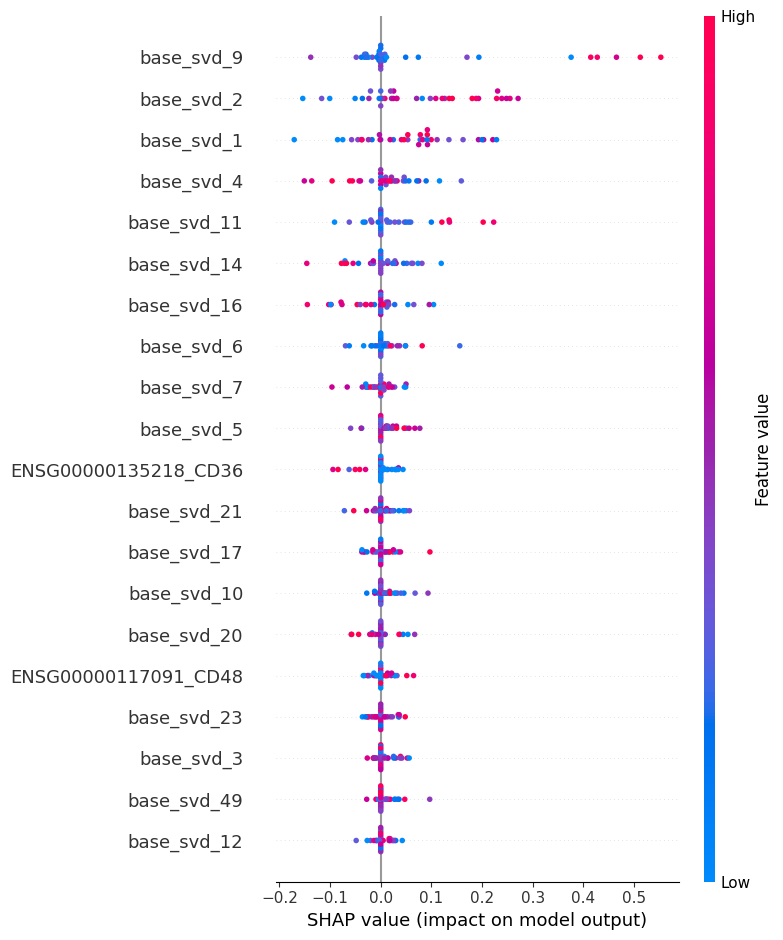

In [33]:
shap.initjs()
shap.summary_plot(shap_values[0], xtest.drop(['cell_id', 'cell_type'], axis=1), feature_names=xtest.drop(['cell_id', 'cell_type'], axis=1).columns)

# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

### svd contributions:

In [34]:
svd_comp_norm_64 = np.loadtxt('/dss/dsshome1/02/di93zoj/valentina/open-problems-multimodal-3rd-solution/code/2.preprocess_to_feature/cite/svd_comp_norm_64.txt', delimiter=',')
pd.DataFrame(svd_comp_norm_64)

0         1             2             3             4      \
0   2.639235e-06  0.000006  8.335013e-07  5.828510e-06  2.757576e-08   
1   2.210340e-04  0.000259  3.542313e-04  5.002610e-04 -4.448949e-07   
2  -1.810057e-05 -0.000001  3.090340e-06 -6.833408e-05  1.926179e-07   
3  -1.260823e-05 -0.000043 -1.826831e-05 -6.362468e-07 -1.077765e-07   
4   1.865809e-05 -0.000028  4.853575e-06  7.330754e-05  8.754653e-07   
5   4.507141e-05  0.000070  3.078210e-05  1.205581e-04 -3.170853e-07   
6  -4.222438e-05 -0.000028  1.913227e-04  6.590015e-05 -9.097179e-07   
7   1.064319e-04  0.000267  1.316242e-04  6.470271e-04  1.296515e-05   
8   5.432840e-05  0.000738 -3.132676e-04  1.541569e-04 -2.304410e-05   
9  -1.530108e-05  0.000005  5.171489e-04 -1.986034e-04 -1.230434e-06   
10  7.718730e-07 -0.000014  1.344215e-04  1.049167e-04 -7.900276e-07   
11  3.873181e-05  0.000151  4.034912e-04 -2.227226e-05  4.642791e-06   
12  8.709911e-06 -0.000003 -4.276094e-05 -1.971095e-05 -4.947868e-07   
13 -2.846732e-05 -0.000011  7.782908e-05  3.199466e-04 -6.729699e-06   
14  1.982615e-05  0.000165  6.615545e-04  1.304833e-04 -7.125747e-06   
15  1.777391e-05  0.000136  7.492973e-05  4.368357e-05  3.671686e-06   
16  3.882615e-05  0.000208 -4.383706e-05  2.287639e-04 -8.565163e-06   
17  7.514089e-06 -0.000213 -4.410017e-03  9.890946e-04 -4.099252e-05   
18  1.072317e-06 -0.000065 -8.966428e-06 -8.001429e-05  6.014353e-06   
19 -2.860193e-04  0.000706  6.718097e-04 -1.151846e-03 -1.984186e-05   
20 -5.133311e-06 -0.000651 -8.307023e-04 -3.812317e-04  9.229208e-06   
21  1.721056e-04  0.000399 -6.772650e-04  5.657737e-04 -6.427063e-07   
22  2.446258e-04 -0.000661  8.363007e-04 -1.159998e-03 -2.716500e-05   
23 -1.998825e-04 -0.000882  5.231121e-04  1.313639e-03 -1.127576e-05   
24  3.596658e-05 -0.000015 -1.351951e-05  1.027478e-04 -1.295435e-06   
25  5.348539e-05  0.000352 -1.011154e-03 -3.443515e-03  2.461564e-05   
26  2.882287e-04  0.000328 -7.931978e-04 -1.136696e-03 -4.443890e-06   
27 -3.576549e-06 -0.000071  1.424854e-04  4.580275e-04  4.731954e-06   
28  3.148303e-05 -0.000167 -1.094139e-03  8.198396e-05 -8.596683e-06   
29 -4.118042e-04  0.000472 -5.568431e-04 -2.844732e-04 -4.081133e-07   
30  7.616529e-05  0.000069  1.617450e-04  1.418115e-04 -8.259189e-06   
31  1.105335e-03  0.001261  2.912728e-03 -2.975273e-04 -2.013368e-06   
32 -6.936781e-05  0.000164  1.001116e-04 -3.552557e-04  5.851195e-07   
33  1.083360e-04 -0.002337  5.616051e-03  7.984909e-03 -6.076289e-05   
34  8.794035e-05  0.000140  7.787171e-04  4.734730e-04  2.977968e-05   
35 -1.318595e-04  0.000245 -5.852855e-04 -3.110599e-04  2.985747e-05   
36  7.073564e-05 -0.000066  9.032086e-05  2.547303e-05  5.596781e-07   
37 -6.118327e-05 -0.000074  4.867167e-04  2.626703e-04  9.198839e-07   
38  2.177405e-05 -0.000875  2.485215e-03 -1.055555e-03 -1.328088e-05   
39  2.337075e-05  0.000096  3.134827e-05 -3.882226e-05  2.270541e-06   
40 -2.680381e-05 -0.000059 -3.074526e-06  2.710308e-04  3.062501e-06   
41 -1.212833e-04 -0.000079  5.781761e-04 -8.017131e-05 -1.155406e-06   
42  1.567753e-05 -0.000155 -4.727805e-04  3.996295e-04  4.299833e-06   
43 -5.447607e-05  0.000115  5.544876e-04 -1.799511e-04 -3.319968e-06   
44  6.287269e-04  0.000262  2.107973e-03 -8.811622e-04  6.423313e-05   
45  1.138102e-04  0.000116 -5.349019e-06  2.199254e-04 -1.455553e-05   
46  1.337171e-04  0.000339  7.309553e-04  3.280355e-04 -2.464475e-05   
47 -7.177152e-05  0.000154 -3.982594e-04 -6.335704e-04 -1.175047e-05   
48 -4.854138e-05 -0.000015  2.292127e-04 -3.874813e-04  5.465351e-06   
49 -9.950092e-05  0.000239 -4.109264e-04 -6.123637e-04 -4.800105e-06   
50  4.135312e-05 -0.000159 -5.267630e-04  3.081881e-05 -4.460154e-06   
51 -3.819407e-05  0.000181  1.834465e-04  2.325896e-04  2.301917e-06   
52  1.241027e-03  0.005600 -1.482641e-02 -2.282404e-03 -6.410502e-04   
53  1.612044e-04  0.000078 -8.069399e-05 -2.445036e-04 -1.878727e-05   
54  1.649496e-04  0.000139  3.284461e-05  4.611860e

In [35]:
# base_svd_2 important feature
svd_comp_norm_64[2]         # => contribution x_2 = -0.00001809 * geneA - 0.00000149 * geneB + 0.0000030917 * geneC + ... + 0.0001264 geneX + 0.00026577 geneY + 0.000175 geneZ

array([-1.81005707e-05, -1.48912909e-06,  3.09033976e-06, ...,
        1.26465457e-04,  2.65773037e-04,  1.75062887e-04])

In [36]:
pd.DataFrame(shap_values[0])

0         1         2         3         4         5         6    \
0   0.000000  0.192832  0.008185  0.014489 -0.017989  0.000000  0.001432   
1   0.000000  0.228491  0.271065  0.000000  0.159001  0.024011  0.008327   
2   0.000000  0.077847  0.230639  0.000000  0.089595  0.020939  0.000000   
3   0.000000  0.134550  0.238815  0.007488  0.044699  0.000000  0.006201   
4   0.000000  0.199944 -0.023331  0.000000  0.000000  0.000000  0.000000   
5  -0.007531 -0.170648  0.032080  0.000000  0.000000 -0.038614  0.000000   
6   0.000000 -0.085127  0.108620  0.000000 -0.061297  0.000000 -0.062048   
7   0.000000  0.024909  0.030809  0.000000 -0.150738  0.000000 -0.017013   
8   0.000000 -0.057441  0.025516 -0.009737 -0.095909  0.000000 -0.033653   
9   0.000000 -0.017187  0.097885 -0.014358 -0.136057  0.000000  0.000000   
10 -0.003199 -0.045072 -0.050542  0.000000  0.010377  0.000000 -0.006813   
11 -0.004677 -0.024215 -0.002894  0.025354  0.009984  0.000000  0.013790   
12  0.000000  0.040852 -0.100571  0.000000  0.020225  0.051074 -0.001097   
13  0.000000  0.053310  0.081859  0.013082  0.009784  0.024147  0.013424   
14  0.000000  0.078117 -0.153797  0.000000  0.016640  0.000000  0.000000   
15  0.000000  0.000000  0.248009  0.000000  0.071253  0.006884  0.010151   
16  0.000000  0.092049  0.192981  0.000000  0.026927  0.011538  0.000000   
17  0.000000  0.045961  0.135087  0.041905  0.055587  0.009046  0.048745   
18  0.012822 -0.038017  0.188274  0.000000  0.115941  0.010802  0.000000   
19  0.004124  0.091919  0.228688  0.052382  0.000000  0.000000  0.000000   
20  0.000000 -0.002517  0.141170  0.000000  0.004758  0.010833  0.048992   
21  0.000000 -0.001144  0.255019  0.039030 -0.042706  0.014174  0.019450   
22  0.000000 -0.036928  0.180423 -0.012913 -0.055927  0.015055  0.081814   
23  0.000000  0.091379  0.070788  0.029509  0.000000  0.000000  0.155960   
24  0.000000 -0.074920  0.121350 -0.011786 -0.039954  0.000000  0.003319   
25  0.000000  0.074932  0.021294  0.038447  0.021564  0.012330  0.000000   
26  0.000000  0.018554  0.024926  0.000000  0.074946  0.047488 -0.010873   
27  0.000000  0.053442  0.126231  0.000000  0.028849 -0.037582  0.022212   
28  0.005675  0.111178  0.019485 -0.014565  0.049022  0.067317 -0.069570   
29  0.000000  0.099565  0.000000 -0.026486  0.046252 -0.059312  0.037274   
30  0.008266  0.203055 -0.036158 -0.007378  0.000000  0.031345  0.032771   
31  0.000000  0.082792  0.003482  0.056185  0.032309  0.077154 -0.019128   
32  0.000000  0.092280 -0.116496  0.000000  0.000000  0.056003  0.000000   
33  0.000000  0.162457 -0.020134  0.007168  0.014717  0.031050  0.000000   
34  0.000000  0.221157  0.000000  0.025870  0.021220  0.046148  0.015395   

         7         8         9         10        11        12        13   \
0   0.000000  0.013198  0.170183  0.013049  0.047003  0.000000  0.000000   
1   0.014841  0.000000 -0.031809  0.000000  0.059231  0.027662  0.013978   
2   0.000000 -0.020023 -0.002924 -0.005547  0.050169 -0.008972 -0.021805   
3   0.046712  0.000000  0.000000  0.000000  0.027702  0.000000 -0.034329   
4   0.000000  0.000000  0.074201  0.017017  0.000000  0.000000  0.000000   
5   0.016306  0.000000  0.000000 -0.027544  0.000000  0.000000  0.000000   
6  -0.012688  0.000000  0.000000  0.000000  0.000000 -0.013177  0.000000   
7  -0.015826  0.000000 -0.031882  0.000000  0.000000 -0.005635  0.000000   
8  -0.024888  0.006097 -0.003474  0.020236  0.000000  0.000000  0.000000   
9   0.049908 -0.001745 -0.003469  0.000000 -0.019571  0.000000 -0.015755   
10  0.021079 -0.006116 -0.007802 -0.011782  0.013240 -0.002495  0.021945   
11 -0.027664  0.000000  0.008145  0.000000  0.000000 -0.000825 -0.006427   
12  0.000000  0.004720 -0.038194  0.000000  0.035667  0.000000  0.015577   
13  0.027512  0.017073  0.000000  0.000000 -0.030857  0.000000  0.056805   
14  0.000000 -0.016678  0.049233  0.045750 -0.062031 -0.004437  0.000000   
15  0.022667  0.000000 -0.024055  0.003828  0.000000  0.

In [37]:
attr_genes_only = np.zeros((len(xtest), 22001))  # Initialize the output array, 35x22001

for cell in range(len(xtest)):
    for gene in range(22001):
        attr_gene = 0
        for svd in range(64):
            attr_gene += shap_values[0][cell][svd] * svd_comp_norm_64[svd][gene]   # this is for one cell -> loop over all cells
        attr_genes_only[cell][gene] = attr_gene
attr_genes_only

array([[ 6.97210114e-05,  9.47299418e-05,  2.02299564e-04, ...,
         1.67305718e-04,  2.72354172e-03, -1.02410506e-04],
       [ 2.81847786e-05,  7.10795307e-05,  7.79670217e-05, ...,
         5.24653882e-04,  3.37111044e-03,  5.36173350e-04],
       [ 2.21046800e-05, -9.72766212e-05,  1.45696027e-04, ...,
         2.83058132e-04,  1.18768310e-03,  2.41630198e-04],
       ...,
       [ 4.70175002e-05,  1.09911239e-04, -2.17423171e-04, ...,
        -3.02258858e-06,  5.50468237e-04, -3.25504444e-04],
       [ 1.67906085e-05,  1.12397294e-05,  2.59982139e-04, ...,
         1.70445791e-04,  1.55290090e-03,  6.91775202e-04],
       [ 8.68292429e-05,  2.96694035e-06,  4.89001749e-04, ...,
         6.42043278e-04,  3.42913417e-03,  5.91014579e-04]])

In [38]:
# add third dimension -> 140x35x22001
attr_genes_only = np.zeros((shap_values.shape[0], len(xtest), 22001))  # Initialize the output array, 140x35x22001

for pred in range(shap_values.shape[0]):
    for cell in range(len(xtest)):
        attr_genes_only[pred, cell] = np.sum(shap_values[pred, cell, :64, None] * svd_comp_norm_64[:64], axis=0)

attr_genes_only

array([[[ 6.97210114e-05,  9.47299418e-05,  2.02299564e-04, ...,
          1.67305718e-04,  2.72354172e-03, -1.02410506e-04],
        [ 2.81847786e-05,  7.10795307e-05,  7.79670217e-05, ...,
          5.24653882e-04,  3.37111044e-03,  5.36173350e-04],
        [ 2.21046800e-05, -9.72766212e-05,  1.45696027e-04, ...,
          2.83058132e-04,  1.18768310e-03,  2.41630198e-04],
        ...,
        [ 4.70175002e-05,  1.09911239e-04, -2.17423171e-04, ...,
         -3.02258858e-06,  5.50468237e-04, -3.25504444e-04],
        [ 1.67906085e-05,  1.12397294e-05,  2.59982139e-04, ...,
          1.70445791e-04,  1.55290090e-03,  6.91775202e-04],
        [ 8.68292429e-05,  2.96694035e-06,  4.89001749e-04, ...,
          6.42043278e-04,  3.42913417e-03,  5.91014579e-04]],

       [[ 1.21160085e-05,  7.13484867e-06,  4.55183463e-05, ...,
          5.03890635e-05,  2.57122103e-04,  1.85013601e-05],
        [-1.13952246e-05,  3.27085012e-06,  1.56876720e-04, ...,
          6.53245344e-05, -2.40112357e

In [39]:
attr_genes_only[0]

array([[ 6.97210114e-05,  9.47299418e-05,  2.02299564e-04, ...,
         1.67305718e-04,  2.72354172e-03, -1.02410506e-04],
       [ 2.81847786e-05,  7.10795307e-05,  7.79670217e-05, ...,
         5.24653882e-04,  3.37111044e-03,  5.36173350e-04],
       [ 2.21046800e-05, -9.72766212e-05,  1.45696027e-04, ...,
         2.83058132e-04,  1.18768310e-03,  2.41630198e-04],
       ...,
       [ 4.70175002e-05,  1.09911239e-04, -2.17423171e-04, ...,
        -3.02258858e-06,  5.50468237e-04, -3.25504444e-04],
       [ 1.67906085e-05,  1.12397294e-05,  2.59982139e-04, ...,
         1.70445791e-04,  1.55290090e-03,  6.91775202e-04],
       [ 8.68292429e-05,  2.96694035e-06,  4.89001749e-04, ...,
         6.42043278e-04,  3.42913417e-03,  5.91014579e-04]])

In [40]:
all_genes = np.loadtxt('/dss/dsshome1/02/di93zoj/valentina/open-problems-multimodal-3rd-solution/code/2.preprocess_to_feature/cite/all_genes_names.txt', dtype=str)
all_genes   # len 22001   (excl. the 84 other genes)   -> need list(all_genes) + gene_ids

array(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', ..., 'ENSG00000162378_ZYG11B',
       'ENSG00000159840_ZYX', 'ENSG00000074755_ZZEF1'], dtype='<U41')

In [41]:
attr_all_22085_genes = np.hstack((attr_genes_only[0], shap_values[0][:,-84:]))
pd.DataFrame(attr_all_22085_genes, columns=list(all_genes)+gene_ids)

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  ENSG00000175899_A2M  \
0           6.972101e-05                  0.000095             0.000202   
1           2.818478e-05                  0.000071             0.000078   
2           2.210468e-05                 -0.000097             0.000146   
3           4.165997e-05                  0.000137             0.000111   
4           6.652597e-05                  0.000105             0.000248   
5          -8.024586e-05                 -0.000062            -0.000152   
6          -6.594745e-05                 -0.000036             0.000045   
7          -2.333402e-05                 -0.000043             0.000037   
8          -3.310876e-05                 -0.000039            -0.000025   
9          -5.511264e-05                 -0.000166             0.000428   
10          5.555586e-06                  0.000029             0.000018   
11          1.638897e-05                 -0.000017             0.000115   
12          2.200335e-05                  0.000022             0.000089   
13         -8.200976e-06                 -0.000049             0.000262   
14          1.819142e-05                 -0.000012            -0.000094   
15          2.931903e-05                 -0.000046            -0.000014   
16          3.857431e-05                 -0.000027            -0.000075   
17          2.586634e-05                  0.000008            -0.000002   
18         -1.314393e-05                  0.000034            -0.000410   
19          9.413668e-06                  0.000085             0.000092   
20          5.318906e-06                  0.000061            -0.000174   
21         -1.147429e-04                 -0.000117            -0.000060   
22         -1.302554e-05                 -0.000003            -0.000151   
23          6.194830e-05                  0.000117            -0.000203   
24         -2.257421e-05                 -0.000029            -0.000090   
25          7.156439e-05                  0.000102            -0.000115   
26         -4.765939e-06                 -0.000014             0.000157   
27          1.156876e-08                  0.000027             0.000271   
28          2.718138e-05                 -0.000061             0.000277   
29         -5.962773e-05                 -0.000076            -0.000091   
30          6.126413e-05                  0.000150            -0.000163   
31          2.238435e-05                 -0.000007            -0.000037   
32          4.701750e-05                  0.000110            -0.000217   
33          1.679061e-05                  0.000011             0.000260   
34          8.682924e-05                  0.000003             0.000489   

    ENSG00000245105_A2M-AS1  ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
0                  0.000112          -6.890290e-06               -0.000175   
1                  0.000208           5.947133e-07               -0.000304   
2                  0.000034           4.868717e-07               -0.000186   
3                 -0.000211           2.957972e-06               -0.000461   
4                  0.000106           1.610746e-07               -0.000149   
5                 -0.000028           9.933237e-07               -0.000054   
6                 -0.000040           1.137498e-06               -0.000111   
7                  0.000008           1.716586e-06               -0.000024   
8                  0.000045           2.095888e-06               -0.000239   
9                  0.000047           1.938631e-05               -0.000433   
10                -0.000024           2.878272e-06                0.000226   
11                 0.000057          -1.900294e-06                0.000160   
12                 0.000111           7.405916e-07                0.000011   
13                 0.000045           1.124032e-05               -0.000201   
14                 0.000105          -2.340833e-07               -0.000090   
15                 0.000087          -1.806435e-06     

In [42]:
test_inputs = scipy.sparse.load_npz(index_path + "test_cite_raw_inputs_values.sparse.npz")
test_inputs = pd.DataFrame(test_inputs.toarray(), columns=list(all_genes)+gene_ids)

# get cell ids
test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_index = test_ids["index"]
len(test_index)

test_inputs.index = test_index

test_inputs

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  \
83d6659a6a32                   0.0                       0.0   
d98594f13d2e                   0.0                       0.0   
5f93d8ffc72f                   0.0                       0.0   
7dfa2699d351                   0.0                       0.0   
6d2533edd0e0                   0.0                       0.0   
...                            ...                       ...   
a9b4d99f1f50                   0.0                       0.0   
0e2c1d0782af                   0.0                       0.0   
a3cbc5aa0ec3                   0.0                       0.0   
75b350243add                   0.0                       0.0   
ad5a949989b2                   0.0                       0.0   

              ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
83d6659a6a32                  0.0                      1.0   
d98594f13d2e                  0.0                      0.0   
5f93d8ffc72f                  0.0                      0.0   
7dfa2699d351                  0.0                      0.0   
6d2533edd0e0                  0.0                      0.0   
...                           ...                      ...   
a9b4d99f1f50                  0.0                      0.0   
0e2c1d0782af                  0.0                      0.0   
a3cbc5aa0ec3                  0.0                      0.0   
75b350243add                  0.0                      0.0   
ad5a949989b2                  0.0                      0.0   

              ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
83d6659a6a32                    0.0                     0.0   
d98594f13d2e                    0.0                     0.0   
5f93d8ffc72f                    0.0                     0.0   
7dfa2699d351                    0.0                     0.0   
6d2533edd0e0                    0.0                     0.0   
...                             ...                     ...   
a9b4d99f1f50                    0.0                     0.0   
0e2c1d0782af                    0.0                     0.0   
a3cbc5aa0ec3                    0.0                     0.0   
75b350243add                    0.0                     0.0   
ad5a949989b2                    0.0                     0.0   

              ENSG00000094914_AAAS  ENSG00000081760_AACS  \
83d6659a6a32                   3.0                   2.0   
d98594f13d2e                   1.0                   1.0   
5f93d8ffc72f                   0.0                   2.0   
7dfa2699d351                   1.0                   2.0   
6d2533edd0e0                   0.0                   0.0   
...                            ...                   ...   
a9b4d99f1f50                   0.0                   0.0   
0e2c1d0782af                   0.0                   0.0   
a3cbc5aa0ec3                   0.0                   0.0   
75b350243add                   1.0                   1.0   
ad5a949989b2                   0.0                   3.0   

              ENSG00000109576_AADAT  ENSG00000103591_AAGAB  \
83d6659a6a32                    1.0                    0.0   
d98594f13d2e                    0.0                    2.0   
5f93d8ffc72f                    0.0                    1.0   
7dfa2699d351                    0.0                    1.0   
6d2533edd0e0                    0.0                    0.0   
...                             ...                    ...   
a9b4d99f1f50                    0.0                    1.0   
0e2c1d0782af                    1.0                    0.0   
a3cbc5aa0ec3                    0.0                    0.0   
75b350243add                    0.0                    0.0   
ad5a949989b2                    0.0                    1.0   

              ENSG00000115977_AAK1  ENSG00000087884_AAMDC  \
83d6659a6a32                   2.0                    1.0   
d98594f13d2e                   2.0                    2.0   
5f93d8ffc72f                   4.0                    1.0   
7dfa2699d351                   1.

In [43]:
# cell ids used in xtest and SHAP:
sample_cells = np.array(xtest['cell_id'])
sample_cells

array(['57b5bce6a192', '23acde7482e4', '45abe0cc1f4e', '7644448dd6aa',
       '18b183acc5df', 'c60b8aadd7e5', 'df410b8196fd', '07da81bf344d',
       'e120ca7cd20e', 'e1c8a5fa7a25', 'ff77eabe8e8f', '0491fa0923ba',
       'eaab20c274e1', '4cd259704f27', '10ded299a09f', 'debe6a2c71f8',
       '3ce9b2028686', 'b9bd8e12c912', 'c6c6e76f6fd7', '71e5309ddaf2',
       'd36b81efc7a8', 'f7c9bd4ab505', '048a80742f44', '7993177403b8',
       '1651c8ffdcf6', '691a56999b8b', '37da221a930c', '091df139689a',
       '6b09c47a80a8', 'aad2186bc7e0', '07ef5166e089', '8282fb6175aa',
       'ed86a212a2fe', 'ac5fdee7f9b5', '9b087c6bdc91'], dtype=object)

In [44]:
xtest_all_genes = test_inputs.loc[sample_cells]
xtest_all_genes

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  \
57b5bce6a192                   0.0                       1.0   
23acde7482e4                   0.0                       0.0   
45abe0cc1f4e                   0.0                       0.0   
7644448dd6aa                   0.0                       0.0   
18b183acc5df                   0.0                       0.0   
c60b8aadd7e5                   0.0                       0.0   
df410b8196fd                   0.0                       0.0   
07da81bf344d                   0.0                       0.0   
e120ca7cd20e                   0.0                       0.0   
e1c8a5fa7a25                   0.0                       0.0   
ff77eabe8e8f                   0.0                       0.0   
0491fa0923ba                   0.0                       0.0   
eaab20c274e1                   0.0                       0.0   
4cd259704f27                   0.0                       0.0   
10ded299a09f                   0.0                       0.0   
debe6a2c71f8                   0.0                       0.0   
3ce9b2028686                   0.0                       0.0   
b9bd8e12c912                   0.0                       0.0   
c6c6e76f6fd7                   0.0                       0.0   
71e5309ddaf2                   0.0                       0.0   
d36b81efc7a8                   0.0                       0.0   
f7c9bd4ab505                   0.0                       0.0   
048a80742f44                   0.0                       0.0   
7993177403b8                   0.0                       0.0   
1651c8ffdcf6                   0.0                       0.0   
691a56999b8b                   0.0                       0.0   
37da221a930c                   0.0                       0.0   
091df139689a                   0.0                       1.0   
6b09c47a80a8                   0.0                       0.0   
aad2186bc7e0                   0.0                       0.0   
07ef5166e089                   1.0                       0.0   
8282fb6175aa                   0.0                       0.0   
ed86a212a2fe                   0.0                       0.0   
ac5fdee7f9b5                   0.0                       0.0   
9b087c6bdc91                   0.0                       0.0   

              ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
57b5bce6a192                  0.0                      0.0   
23acde7482e4                  0.0                      0.0   
45abe0cc1f4e                  0.0                      0.0   
7644448dd6aa                  0.0                      0.0   
18b183acc5df                  0.0                      0.0   
c60b8aadd7e5                  0.0                      0.0   
df410b8196fd                  0.0                      0.0   
07da81bf344d                  0.0                      0.0   
e120ca7cd20e                  0.0                      0.0   
e1c8a5fa7a25                  0.0                      0.0   
ff77eabe8e8f                  0.0                      0.0   
0491fa0923ba                  0.0                      0.0   
eaab20c274e1                  0.0                      0.0   
4cd259704f27                  0.0                      0.0   
10ded299a09f                  0.0                      0.0   
debe6a2c71f8                  0.0                      0.0   
3ce9b2028686                  0.0                      0.0   
b9bd8e12c912                  0.0                      0.0   
c6c6e76f6fd7                  0.0                      0.0   
71e5309ddaf2                  0.0                      0.0   
d36b81efc7a8                  0.0                      0.0   
f7c9bd4ab505                  0.0                      0.0   
048a80742f44                  0.0                      0.0   
7993177403b8                  0.0                      0.0   
1651c8ffdcf6                  0.0                      0.0   
691a56999b8b                  0.0                      0.0   
37da221a930c                  0.0  

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


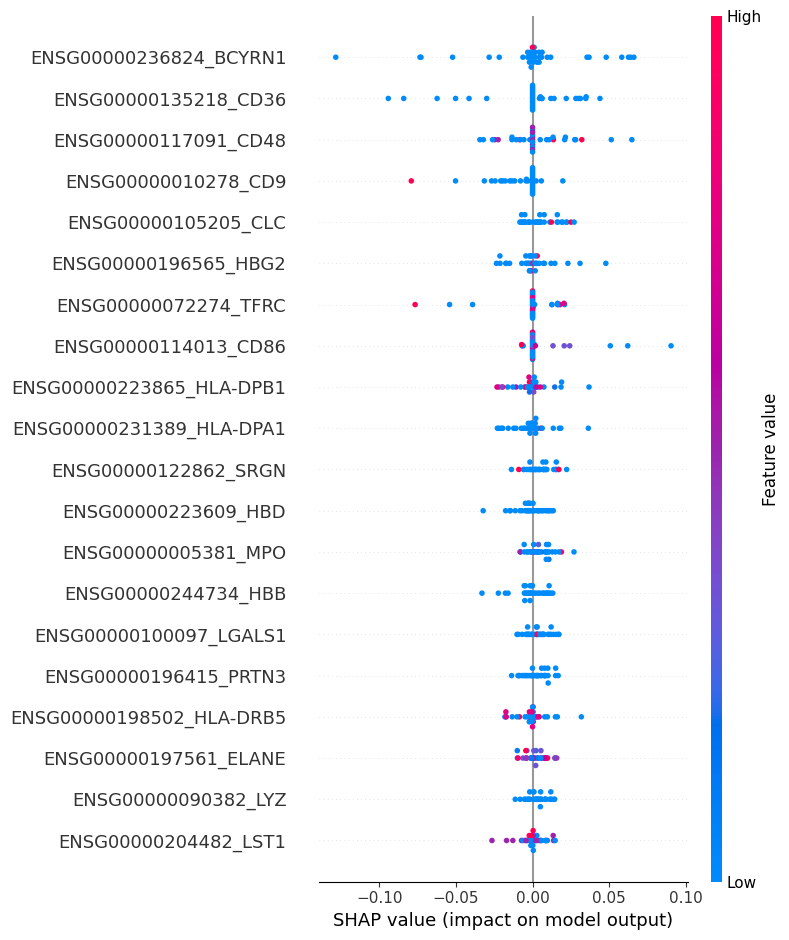

In [46]:
shap.initjs()
shap.summary_plot(attr_all_22085_genes, xtest_all_genes, feature_names=xtest_all_genes.columns)